# Notebook Take 3

## Imports

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [489]:
pd.options.display.max_rows = 999

In [490]:
# Reading in data
years = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
         2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dfs = []
for year in years:
    df = pd.read_csv(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv')
    df['year'] = year
    dfs.append(df)
match_df = pd.concat(dfs)

## Data Exploration

In [491]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101317 entries, 0 to 1925
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          101317 non-null  object 
 1   tourney_name        101317 non-null  object 
 2   surface             101317 non-null  object 
 3   draw_size           101317 non-null  int64  
 4   tourney_level       101317 non-null  object 
 5   tourney_date        101317 non-null  int64  
 6   match_num           101317 non-null  int64  
 7   winner_id           101317 non-null  int64  
 8   winner_seed         41029 non-null   object 
 9   winner_entry        12294 non-null   object 
 10  winner_name         101317 non-null  object 
 11  winner_hand         101308 non-null  object 
 12  winner_ht           99024 non-null   float64
 13  winner_ioc          101317 non-null  object 
 14  winner_age          101314 non-null  float64
 15  loser_id            101317 non-null 

## Data Cleaning

### Dropping initial unecessary columns

In [492]:
# Tournament id is not going to be helpful with overall predictions but could be for individual tournaments
# Country of origin not needed
# winner_entry and seed are basically same thing so only need one
# score not needed if we know who already won
# hand not really necessary?
match_df = match_df.drop(columns = ['tourney_id', 'tourney_name', 'tourney_level', 'winner_ioc', 'loser_ioc',
                                   'match_num', 'winner_entry', 'loser_entry', 'score', 'winner_hand', 'loser_hand'])

### Dealing with Nan's

We are going to start with winner and loser seed. We are assuming nan values are players that are not seeded at tournaments

In [493]:
match_df['winner_seed'].unique()

array([nan, 8.0, 5.0, 6.0, 2.0, 3.0, 7.0, 1.0, 4.0, 16.0, 13.0, 12.0,
       14.0, 10.0, 11.0, 9.0, 15.0, 31.0, 18.0, 23.0, 25.0, 29.0, 21.0,
       28.0, 22.0, 26.0, 24.0, 17.0, 32.0, 30.0, 20.0, 27.0, 19.0, 33.0,
       35.0, '1', '2', '3', '6', '7', '8', '4', '5', '25', '17', '16',
       '19', '31', 'WC', 'Q', '23', '14', '10', '18', '28', '32', '11',
       '15', '20', '26', '27', '24', '9', '13', '12', '33', '29', '30',
       '21', '22', 'LL'], dtype=object)

We are replacing nulls with 0's because they do not have a seed. We are also doing this for lucky loser (LL) and Wild Card as 0's as well since these players are not seeded.

In [494]:
match_df['winner_seed'] = match_df['winner_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

In [495]:
# Replacing loser nulls
match_df['loser_seed'] = match_df['loser_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

For the nulls in winner_ht and loser_ht, we are going to replace them with mode. Most ATP players are about 6' 1" or about 185 cm.

In [496]:
match_df['winner_ht'].unique()

array([193., 198., 190., 178., 185., 173., 175., 188., 180., 183., 196.,
       170., 201.,  nan, 203., 165., 160., 168., 174., 208., 206., 191.,
       182., 181., 194., 172., 189., 176., 186., 211., 163.])

In [497]:
match_df['winner_ht'].mode()

0    185.0
dtype: float64

In [498]:
match_df['winner_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

In [499]:
match_df['loser_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

Winner_age and loser_age both have one null each. We are just going to fill them with the mode of ages for simplicity.

In [501]:
match_df['winner_age'].fillna(match_df['winner_age'].mode()[0], inplace = True)

In [502]:
match_df['loser_age'].fillna(match_df['winner_age'].mode()[0], inplace = True)

In [500]:
print(match_df['winner_age'].mode())
print(match_df['loser_age'].mode())

0    26.0
dtype: float64
0    26.0
dtype: float64


We are going to drop null values for game data. We fill it would be inaccurate to try and fill matches with game data based on measures of central tendency.

In [503]:
match_df = match_df.dropna()

### Converting Datatypes to Numeric
We do not have any nulls now. To compare our columns and make models in the future, we need to get our categorical columns to become numeric. The first columns we are going to change is Surface. Surface has 3 columns, so we are going to encode it.

In [504]:
match_df["surface"] = match_df["surface"].astype('category')
match_df.dtypes
match_df["surface_cat"] = match_df["surface"].cat.codes

Now, since we have surface_cats as an int, we no longer need 'surface'

In [505]:
match_df = match_df.drop(columns = 'surface')

Next, we are going to change winner and loser seeds to integers

In [506]:
match_df['winner_seed'] = match_df['winner_seed'].astype(int)
match_df['loser_seed'] = match_df['loser_seed'].astype(int)

For our round column, we are going to remove 'R' from values such as 'R32'. We are also going to drop 'Er', 'BR' which stand for bye and bye round. We are also going to get rid of matches with 'RR'. This stands for round robin and these matches typically do not affect rankings and are uneeded.

In [507]:
match_df['round'].value_counts()

R32     31165
R16     16367
R64     14431
R128     8694
QF       8221
SF       4200
F        2145
RR       1858
ER         32
BR          2
Name: round, dtype: int64

In [508]:
match_df = match_df.loc[match_df['round'] != 'RR']
match_df = match_df.loc[match_df['round'] != 'BR']
match_df = match_df.loc[match_df['round'] != 'ER']

In [509]:
match_df['round'] = match_df['round'].str.replace('R', '')

In [510]:
match_df['round'].unique()

array(['32', '16', 'QF', 'SF', 'F', '128', '64'], dtype=object)

The last thing we are doing for round is replacing QF, F, and SF with the number of players in those rounds.

In [511]:
match_df['round'] = match_df['round'].str.replace('QF', '8').replace('SF', '4').replace('F', '2')

In [512]:
match_df['round'] = match_df['round'].astype(int)

In [513]:
match_df = match_df.reset_index(drop=True)

## Creating fav_win  target column

This column will allow us to see if the favorite won the match or not. This will be our target columns for when we begin modelling.

In [514]:
winners_r = match_df['winner_rank']
losers_r = match_df['loser_rank']

In [515]:
favorites = []
for i in list(range(0, 85223)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

In [516]:
match_df['fav_win'] = favorites

In [517]:
match_df['fav_win'].value_counts()

True     55166
False    30057
Name: fav_win, dtype: int64

### Aggregate player stats
In order for our model to not have target/data leakage, we are changing the columns to describe their career averages (career stats limited to results within this data's timeframe). Each row will still represent a match with two competitors, but the other columns describing matchplay will not be specific to that individual match, therefore the model should not be using future data to predict future results.

In [518]:
match_df['tourney_date'] = pd.to_datetime(match_df['tourney_date'], format='%Y%m%d')

In [519]:
match_df['prev_year'] = match_df['tourney_date'].dt.year - 1

In [520]:
match_dfW = match_df.groupby(['winner_id', 'year', 'surface_cat']).mean()[['w_df',             
'w_svpt',             
   'w_1stIn',            
   'w_1stWon',           
   'w_2ndWon',           
'w_SvGms',            
  'w_bpSaved',          
  'w_bpFaced',
                                                'w_ace'
    ]]

In [521]:
match_dfL = match_df.groupby(['loser_id', 'year', 'surface_cat']).mean()[['l_ace',              
  'l_df',               
  'l_svpt',             
  'l_1stIn',            
 'l_1stWon',           
  'l_2ndWon',           
  'l_SvGms',            
 'l_bpSaved',          
  'l_bpFaced',
    ]]

In [522]:
match_df = match_df.merge(match_dfW, 
              left_on = ['winner_id', 'prev_year', 'surface_cat'], 
              right_on = ['winner_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_winner'),
              how = 'left')

In [523]:
match_df = match_df.merge(match_dfL, 
              left_on = ['loser_id', 'prev_year', 'surface_cat'], 
              right_on = ['loser_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_loser'),
              how = 'left')

In [524]:
match_df = match_df.drop(columns = ['w_ace_match',
       'w_df_match', 'w_svpt_match', 'w_1stIn_match', 'w_1stWon_match',
       'w_2ndWon_match', 'w_SvGms_match', 'w_bpSaved_match', 'w_bpFaced_match',
       'l_ace_match', 'l_df_match', 'l_svpt_match', 'l_1stIn_match',
       'l_1stWon_match', 'l_2ndWon_match', 'l_SvGms_match', 'l_bpSaved_match',
       'l_bpFaced_match', ])

In [525]:
match_df['year'].unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int64)

## Differences
In order for us to engineer the data in terms of favorite, which will allow our model to have an easily identifiable target, we have to include a column that outputs boolean True or False to whether or not the favorite won. This is calculated by looking at player rankings going into any individual match, which was provided in the original dataset.

In [526]:
favorites = []
for i in list(range(0, 85223)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

In [527]:
match_df['fav_win'] = favorites

In [528]:
match_df = match_df.drop(columns = ['winner_seed', 'loser_seed', 'winner_rank_points', 'loser_rank_points', 'minutes'])

In [529]:
fav_win_T = match_df.loc[match_df['fav_win'] == True]

In [530]:
fav_win_T['fav_rank_diff'] = fav_win_T['winner_rank'] - fav_win_T['loser_rank']
fav_win_T['fav_bpFaced_diff'] = fav_win_T['w_bpFaced_winner'] - fav_win_T['l_bpFaced_loser']
fav_win_T['fav_bpSaved_diff'] = fav_win_T['w_bpSaved_winner'] - fav_win_T['l_bpSaved_loser']
fav_win_T['fav_SvGms_diff'] = fav_win_T['w_SvGms_winner'] - fav_win_T['l_SvGms_loser']
fav_win_T['fav_2ndWon_diff'] = fav_win_T['w_2ndWon_winner'] - fav_win_T['l_2ndWon_loser']
fav_win_T['fav_1stWon_diff'] = fav_win_T['w_1stWon_winner'] - fav_win_T['l_1stWon_loser']
fav_win_T['fav_1stIn_diff'] = fav_win_T['w_1stIn_winner'] - fav_win_T['l_1stIn_loser']
fav_win_T['fav_svpt_diff'] = fav_win_T['w_svpt_winner'] - fav_win_T['l_svpt_loser']
fav_win_T['fav_df_diff'] = fav_win_T['w_df_winner'] - fav_win_T['l_df_loser']
fav_win_T['fav_ace_diff'] = fav_win_T['w_ace_winner'] - fav_win_T['l_ace_loser']
fav_win_T['fav_age_diff'] = fav_win_T['winner_age'] - fav_win_T['loser_age']
fav_win_T['fav_ht_diff'] = fav_win_T['winner_ht'] - fav_win_T['loser_ht']

In [531]:
# dropping not diff columns
fav_win_T = fav_win_T.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [532]:
fav_win_F = match_df.loc[match_df['fav_win'] == False]

In [533]:
fav_win_F['fav_rank_diff'] =fav_win_F['loser_rank'] - fav_win_F['winner_rank'] 
fav_win_F['fav_bpFaced_diff'] =fav_win_F['l_bpFaced_loser'] - fav_win_F['w_bpFaced_winner']  
fav_win_F['fav_bpSaved_diff'] =fav_win_F['l_bpSaved_loser'] - fav_win_F['w_bpSaved_winner']  
fav_win_F['fav_SvGms_diff'] =fav_win_F['l_SvGms_loser'] - fav_win_F['w_SvGms_winner'] 
fav_win_F['fav_2ndWon_diff'] =fav_win_F['l_2ndWon_loser'] - fav_win_F['w_2ndWon_winner']  
fav_win_F['fav_1stWon_diff'] =fav_win_F['l_1stWon_loser'] - fav_win_F['w_1stWon_winner']  
fav_win_F['fav_1stIn_diff'] =fav_win_F['l_1stIn_loser'] - fav_win_F['w_1stIn_winner'] 
fav_win_F['fav_svpt_diff'] =fav_win_F['l_svpt_loser'] - fav_win_F['w_svpt_winner'] 
fav_win_F['fav_df_diff'] =fav_win_F['l_df_loser'] - fav_win_F['w_df_winner']  
fav_win_F['fav_ace_diff'] =fav_win_F['l_ace_loser'] - fav_win_F['w_ace_winner']  
fav_win_F['fav_age_diff'] =fav_win_F['loser_age'] - fav_win_F['winner_age'] 
fav_win_F['fav_ht_diff'] =fav_win_F['loser_ht'] - fav_win_F['winner_ht'] 

In [534]:
fav_win_F = fav_win_F.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [609]:
agg_df = pd.concat([fav_win_T, fav_win_F]).sort_values(by = 'tourney_date')

In [539]:
pd.options.display.max_columns = 999

In [610]:
agg_df.head()

,draw_size,tourney_date,winner_id,winner_name,loser_id,loser_name,best_of,round,winner_rank,loser_rank,year,surface_cat,fav_win,prev_year,fav_rank_diff,fav_bpFaced_diff,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff,fav_age_diff,fav_ht_diff
0,32,1991-01-07,101142,Emilio Sanchez,101746,Renzo Furlan,3,32,9.0,78.0,1991,3,True,1990,-69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
59,32,1991-01-07,101098,Guy Forget,101529,Michael Stich,3,2,16.0,38.0,1991,3,True,1990,-22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-3.0
58,32,1991-01-07,101529,Michael Stich,101320,Magnus Gustafsson,3,4,38.0,32.0,1991,3,False,1990,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,-8.0
53,32,1991-01-07,101196,Derrick Rostagno,101073,Martin Jaite,3,8,49.0,36.0,1991,3,False,1990,-13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-7.0
50,32,1991-01-07,101529,Michael Stich,101084,Jakob Hlasek,3,16,38.0,17.0,1991,3,False,1990,-21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,-5.0


## Model-less Baseline

Let's see how we can predict future matches prior to making any models

In [541]:
agg_df['fav_win'].value_counts()

True     55166
False    30057
Name: fav_win, dtype: int64

In [542]:
55166 / len(agg_df['fav_win'])

0.6473135186510683

Our model-less baseline is about 65% accurate if you were to predict that the favorite won every time.

## Splitting Data
Seperating our data into a train-test split including a hold out set of the past two years for our final model to test and be evaluated on.

In [613]:
test_df = agg_df.loc[agg_df['year'] >= 2021]

In [614]:
X = agg_df.drop(columns='fav_win')
y = agg_df['fav_win']
# Preparing our hold out data for train test split
X_cols = X.columns
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=2022, test_size=len(test_df), shuffle = False)
X_test, X_hold, y_test, y_hold =train_test_split(X_test, y_test, test_size=500, shuffle=False)

In [615]:
agg_df['fav_win'].value_counts()

True     55166
False    30057
Name: fav_win, dtype: int64

In [616]:
X_train = X_train.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                                 'winner_rank', 'loser_rank', 'year'])
X_test = X_test.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                               'winner_rank', 'loser_rank', 'year'])
X_hold = X_hold.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year', 
                                'winner_rank', 'loser_rank', 'year'])

## Function

In [617]:
def evaluate(model,Xtr,Xte,ytr,yte):
    train_preds = model.predict(Xtr)
    test_preds = model.predict(Xte)

    train_probas = model.predict_proba(Xtr)[:,1]
    test_probas = model.predict_proba(Xte)[:,1]
    
    plot_confusion_matrix(model,Xte,yte)
    
    plot_roc_curve(model,Xte,yte)
    
    print(f"Train Accuracy: {accuracy_score(ytr,train_preds):.4f}")
    print(f"Train F1: {f1_score(ytr,train_preds):.4f}")
    print(f"Train Precision: {precision_score(ytr,train_preds):.4f}")
    print(f"Train Recall: {recall_score(ytr,train_preds):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(ytr,train_probas):.4f}")
    print('*'*20)
    print(f"Test Accuracy: {accuracy_score(yte,test_preds):.4f}")
    print(f"Test F1: {f1_score(yte,test_preds):.4f}")
    print(f"Test Precision: {precision_score(yte,test_preds):.4f}")
    print(f"Test Recall: {recall_score(yte,test_preds):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(yte,test_probas):.4f}")

## LOGREG MODEL 1

In [618]:
si = SimpleImputer()

si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)
X_hold_im = si.transform(X_hold)

In [619]:
scaler = StandardScaler()

scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)
X_hold_sc = scaler.transform(X_hold_im)

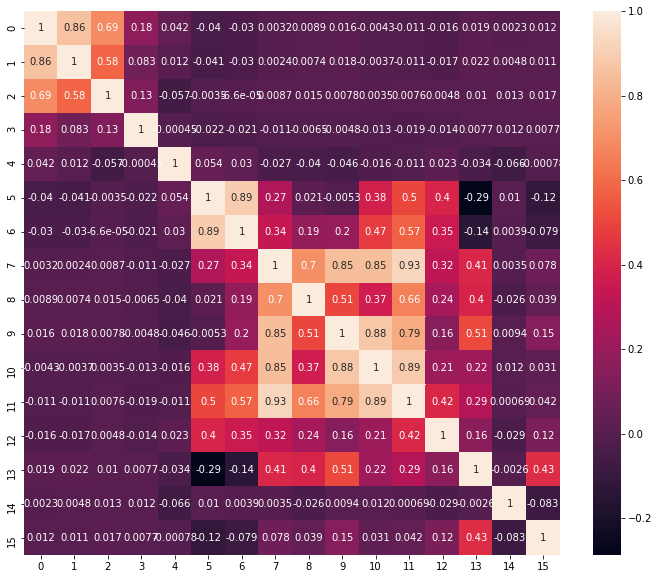

In [620]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(X_train_sc).corr(), annot=True);

In [621]:
logreg = LogisticRegression(random_state = 42)

logreg.fit(X_train_sc,y_train)

LogisticRegression(random_state=42)

In [622]:
y_train.value_counts(normalize=True)

True     0.648186
False    0.351814
Name: fav_win, dtype: float64

In [623]:
y_test.value_counts(normalize=True)

True     0.631028
False    0.368972
Name: fav_win, dtype: float64

Train Accuracy: 0.8741
Train F1: 0.9093
Train Precision: 0.8530
Train Recall: 0.9736
Train ROC-AUC: 0.9510
********************
Test Accuracy: 0.8641
Test F1: 0.9007
Test Precision: 0.8359
Test Recall: 0.9764
Test ROC-AUC: 0.9503


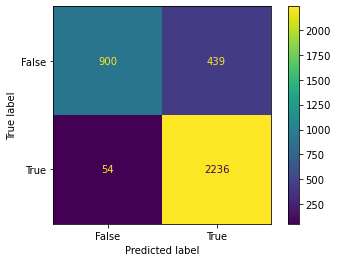

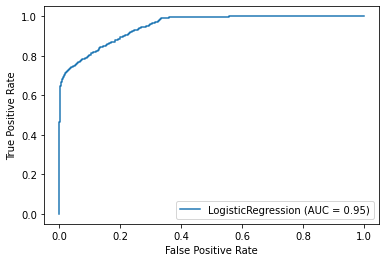

In [624]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Model 2: Decision Tree

In [597]:
tree = DecisionTreeClassifier(random_state = 42,max_depth = 5)

tree.fit(X_train_im, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Train Accuracy: 0.8633
Train F1: 0.9028
Train Precision: 0.8373
Train Recall: 0.9794
Train ROC-AUC: 0.9384
********************
Test Accuracy: 0.8462
Test F1: 0.8885
Test Precision: 0.8170
Test Recall: 0.9737
Test ROC-AUC: 0.9310


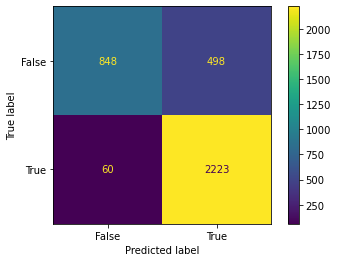

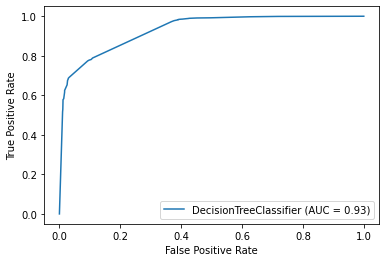

In [598]:
evaluate(tree,X_train_im,X_test_im,y_train,y_test)

## Model 3: Naive Bayes

In [599]:
clf_nb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB()),
])

clf_nb.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('naive_bayes', GaussianNB())])

Train Accuracy: 0.8202
Train F1: 0.8696
Train Precision: 0.8207
Train Recall: 0.9246
Train ROC-AUC: 0.8788
********************
Test Accuracy: 0.7950
Test F1: 0.8474
Test Precision: 0.7968
Test Recall: 0.9049
Test ROC-AUC: 0.8729


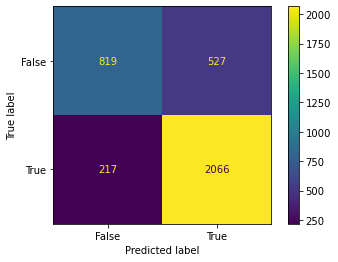

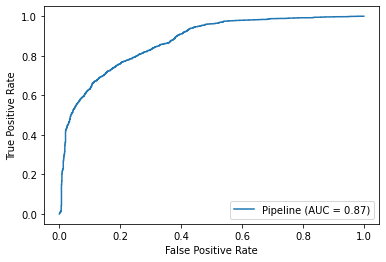

In [600]:
evaluate(clf_nb,X_train_im,X_test_im,y_train,y_test)

## Model 4: Random Forest

In [579]:
# smote = SMOTE(random_state=42)
# X_train_im, y_train = smote.fit_resample(X_train_im,y_train)

In [601]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42,max_depth = 10)),
])

clf_rf.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
cross_validate(clf_rf,X_train_im,y_train,scoring='accuracy',return_train_score = True)

Train Accuracy: 0.8808
Train F1: 0.9151
Train Precision: 0.8497
Train Recall: 0.9914
Train ROC-AUC: 0.9625
********************
Test Accuracy: 0.8567
Test F1: 0.8962
Test Precision: 0.8235
Test Recall: 0.9829
Test ROC-AUC: 0.9507


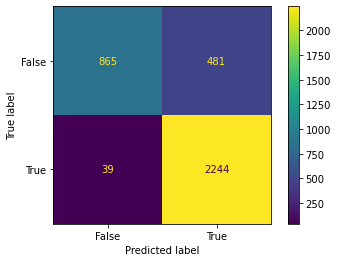

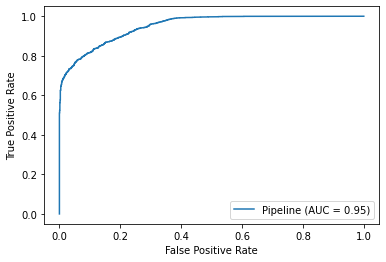

In [602]:
evaluate(clf_rf,X_train_im,X_test_im,y_train,y_test)

## Model 5: Random Forest with Grid Search

In [ ]:
param_grid = {
    "random forest__criterion":['gini','entropy'],
    "random forest__max_depth": [1,2,3,4,5,10,15],
    "random forest__min_samples_leaf": [1,2,5,10,12,15],
    "random forest__min_samples_split": [2,4,6,8]
}

In [ ]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42)),
])

clf_rf.fit(X_train_im,y_train)

In [ ]:
gs = GridSearchCV(clf_rf,param_grid,cv = 5,scoring = 'accuracy')

gs.fit(X_train_im,y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
evaluate(gs.best_estimator_,X_train_im,X_test_im,y_train,y_test)